In [1]:
import os, random, time, math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import clear_output, display

# Matplotlib 内联显示
%matplotlib inline

# 统一随机种子
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [2]:
BATCH_SIZE = 128

tfm = transforms.Compose([
    transforms.ToTensor(),                       # [0,1]
    transforms.Normalize((0.1307,), (0.3081,))   # 官方统计
])

trainval = datasets.MNIST(root="./data", train=True, download=True, transform=tfm)
testset  = datasets.MNIST(root="./data", train=False, download=True, transform=tfm)

# 划分 train/val（90% / 10%）
n_train = int(0.9 * len(trainval))
n_val = len(trainval) - n_train
trainset, valset = random_split(trainval, [n_train, n_val], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(valset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(testset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

len(trainset), len(valset), len(testset)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.09MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.58MB/s]


(54000, 6000, 10000)

In [3]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),                 # 1x28x28 -> 784
            nn.Linear(28*28, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 10)
        )
    def forward(self, x): return self.net(x)

class SmallCNN(nn.Module):
    """ Conv-BN-ReLU x2 -> MaxPool -> Conv-BN-ReLU -> GAP -> FC """
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),   # 28 -> 14
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
        )
        self.gap  = nn.AdaptiveAvgPool2d(1)   # -> (N,64,1,1)
        self.fc   = nn.Linear(64, 10)

    def forward(self, x):
        x = self.features(x)                  # (N,64,14,14)
        x = self.gap(x).squeeze(-1).squeeze(-1)  # (N,64)
        return self.fc(x)


In [4]:
def accuracy_from_logits(logits, y):
    return (logits.argmax(dim=1) == y).float().mean().item()

def plot_live(history, title):
    """ history: dict(epoch, train_loss, val_loss, train_acc, val_acc) """
    epochs = history["epoch"]
    plt.figure(figsize=(11,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], marker="o", label="Train Loss")
    plt.plot(epochs, history["val_loss"],   marker="s", label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"{title} - Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], marker="o", label="Train Acc")
    plt.plot(epochs, history["val_acc"],   marker="s", label="Val Acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title(f"{title} - Accuracy")
    plt.legend()
    plt.tight_layout()
    display(plt.gcf())
    plt.close()

def train_eval_live(model, train_loader, val_loader, epochs=5, lr=1e-3, title="Model"):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.CrossEntropyLoss()

    history = {"epoch": [], "train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for ep in range(1, epochs+1):
        # ---- Train
        model.train()
        running_loss, running_acc, n = 0.0, 0.0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = crit(logits, y)
            opt.zero_grad(); loss.backward(); opt.step()

            bs = y.size(0)
            running_loss += loss.item() * bs
            running_acc  += accuracy_from_logits(logits, y) * bs
            n += bs

        tr_loss = running_loss / n
        tr_acc  = running_acc  / n

        # ---- Val
        model.eval()
        v_loss, v_acc, nval = 0.0, 0.0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                loss = crit(logits, y)
                bs = y.size(0)
                v_loss += loss.item() * bs
                v_acc  += accuracy_from_logits(logits, y) * bs
                nval   += bs

        va_loss = v_loss / nval
        va_acc  = v_acc  / nval

        history["epoch"].append(ep)
        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(va_acc)

        # ---- 实时曲线
        clear_output(wait=True)
        print(f"[{title}] Epoch {ep}/{epochs} | "
              f"train_loss={tr_loss:.4f} train_acc={tr_acc:.4f} | "
              f"val_loss={va_loss:.4f} val_acc={va_acc:.4f}")
        plot_live(history, title)

    return model, history


[CNN] Epoch 5/5 | train_loss=0.1210 train_acc=0.9690 | val_loss=0.5536 val_acc=0.8010


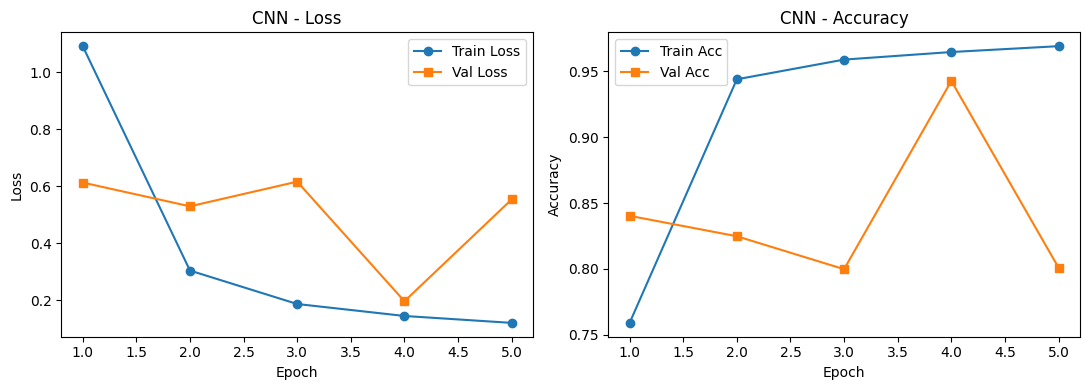

In [5]:
EPOCHS = 5
LR = 1e-3

mlp = MLP()
mlp, hist_mlp = train_eval_live(mlp, train_loader, val_loader, epochs=EPOCHS, lr=LR, title="MLP")

cnn = SmallCNN()
cnn, hist_cnn = train_eval_live(cnn, train_loader, val_loader, epochs=EPOCHS, lr=LR, title="CNN")


[MLP] Test Accuracy: 0.9805


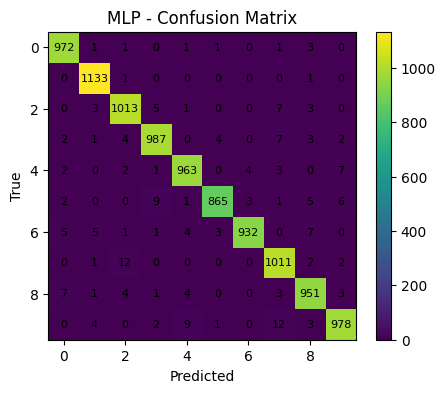

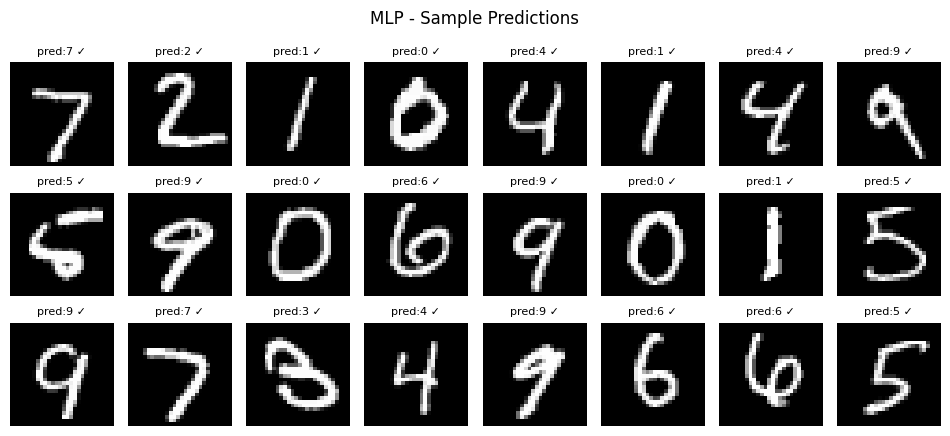

              precision    recall  f1-score   support

           0     0.9818    0.9918    0.9868       980
           1     0.9861    0.9982    0.9921      1135
           2     0.9759    0.9816    0.9787      1032
           3     0.9811    0.9772    0.9792      1010
           4     0.9797    0.9807    0.9802       982
           5     0.9897    0.9697    0.9796       892
           6     0.9925    0.9729    0.9826       958
           7     0.9675    0.9835    0.9754      1028
           8     0.9724    0.9764    0.9744       974
           9     0.9800    0.9693    0.9746      1009

    accuracy                         0.9805     10000
   macro avg     0.9807    0.9801    0.9804     10000
weighted avg     0.9806    0.9805    0.9805     10000

[CNN] Test Accuracy: 0.8191


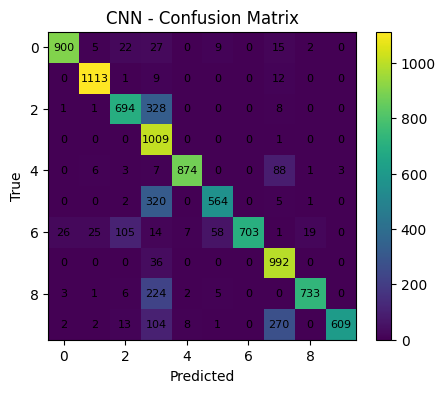

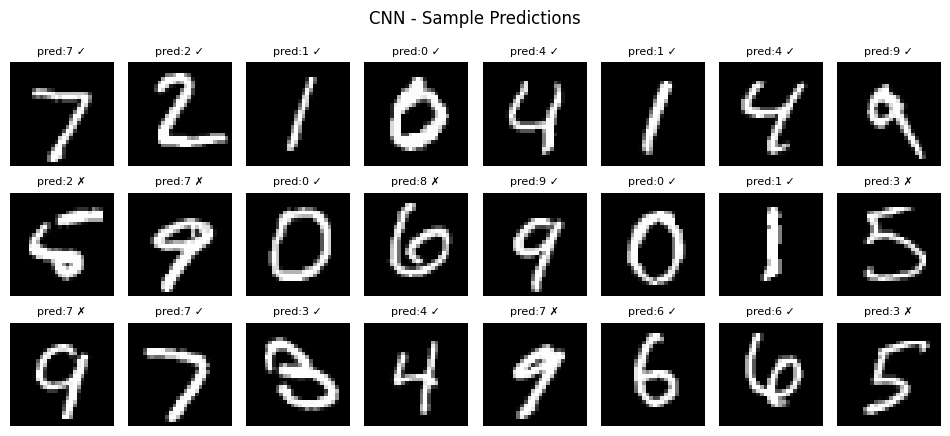

              precision    recall  f1-score   support

           0     0.9657    0.9184    0.9414       980
           1     0.9653    0.9806    0.9729      1135
           2     0.8203    0.6725    0.7391      1032
           3     0.4856    0.9990    0.6535      1010
           4     0.9809    0.8900    0.9333       982
           5     0.8854    0.6323    0.7377       892
           6     1.0000    0.7338    0.8465       958
           7     0.7126    0.9650    0.8198      1028
           8     0.9696    0.7526    0.8474       974
           9     0.9951    0.6036    0.7514      1009

    accuracy                         0.8191     10000
   macro avg     0.8781    0.8148    0.8243     10000
weighted avg     0.8771    0.8191    0.8261     10000

Final Test Accuracy | MLP: 0.9805  vs  CNN: 0.8191


In [6]:
def eval_on_test(model, test_loader, title="Model", show_samples=True, n_show=24):
    model.eval()
    y_true, y_pred, sample_imgs = [], [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(y.numpy())
            if show_samples and len(sample_imgs) < n_show:
                sample_imgs.append(x.cpu())
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    acc = (y_true == y_pred).mean()
    print(f"[{title}] Test Accuracy: {acc:.4f}")

    # 混淆矩阵
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"{title} - Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center", fontsize=8)
    plt.colorbar(); plt.show()

    # 样例可视化
    if show_samples and len(sample_imgs) > 0:
        imgs = torch.cat(sample_imgs, dim=0)[:n_show]  # (N,1,28,28)
        logits = model(imgs.to(device))
        preds = logits.argmax(dim=1).cpu().numpy()
        rows, cols = math.ceil(n_show/8), 8
        plt.figure(figsize=(cols*1.2, rows*1.5))
        for i in range(n_show):
            if i >= len(imgs): break
            plt.subplot(rows, cols, i+1)
            plt.imshow(imgs[i,0].numpy(), cmap="gray")
            ok = "✓" if preds[i]==y_true[i] else "✗"
            plt.title(f"pred:{preds[i]} {ok}", fontsize=8)
            plt.axis("off")
        plt.suptitle(f"{title} - Sample Predictions", fontsize=12)
        plt.tight_layout()
        plt.show()

    # 分类报告
    print(classification_report(y_true, y_pred, digits=4))
    return acc

acc_mlp = eval_on_test(mlp, test_loader, title="MLP")
acc_cnn = eval_on_test(cnn, test_loader, title="CNN")

print("="*50)
print(f"Final Test Accuracy | MLP: {acc_mlp:.4f}  vs  CNN: {acc_cnn:.4f}")
